# **Feature Engineering**

## Objectives

* We will create pipelines for preprocessing the data we have collected. The choices we make will be influenced on the previous notebook.

* However, we will make our pipelines flexible so that we can test the impact of our choices when we train multiple models.

## Inputs

* We will use the cleaned CSV file created at the end of notebook 2.
* Insight we gained from the previous notebook.

## Outputs

* Pipelines for transforming our data.
* Train and test sets for our models to consume.
* An experimentation set consisting of the most recent season in the data set.


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [21]:
import os
home_dir = '/workspace/pp5-ml-dashboard'
csv_dir ='clean/csv' 
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our cleaned dataset as well as some of the packages that we will be using.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport
from src.utils import get_df, save_df

game_data = get_df('game_data_clean', csv_dir)


## Section 1: Minor adjustments
We will make some minor adjustments, like we did at the beginning of the last notebook.

In [23]:
game_data.head()

,season_id,team_id_home,game_id,wl_home,min,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,Day,Month,Year
0,21985,1610612737,28500005,L,240,41.0,92.0,0.0,3.0,9.0,...,40.0,21.0,11.0,7.0,17.0,19.0,100.0,25,10,1985
1,21985,1610612758,28500006,L,240,39.0,88.0,0.0,2.0,26.0,...,42.0,19.0,7.0,7.0,18.0,32.0,108.0,25,10,1985
2,21985,1610612765,28500010,W,240,39.0,88.0,0.0,1.0,40.0,...,41.0,27.0,10.0,7.0,20.0,32.0,116.0,25,10,1985
3,21985,1610612762,28500011,L,240,42.0,82.0,0.0,2.0,24.0,...,47.0,23.0,10.0,7.0,19.0,28.0,112.0,25,10,1985
4,21985,1610612744,28500008,L,240,36.0,91.0,0.0,4.0,33.0,...,44.0,26.0,11.0,3.0,22.0,40.0,119.0,25,10,1985


We are going to modify the data frame before doing any feature scaling or transformations of our data. We are going to drop metadata columns like `'game_id'`, `'team_id'`, as well as `'Day'` and `'Month'`, and `'Year'`. We will also need to change the column `'wl_home'`. We will also a column to distinguish between regular season and play off games. We will also replace `'season_id'` with something more informative.

In [24]:
game_pre = game_data.drop(labels=['min', 'team_id_home', 'team_id_away', 'Day', 'Month','Year'], axis=1)
game_pre.set_index('game_id', inplace=True)
game_pre['home_wins'] = game_pre.apply(lambda x: 1 if x['wl_home'] == 'W' else 0, axis=1)
game_pre.drop(labels=['wl_home'], axis=1, inplace=True)

game_pre['play_off'] = game_pre.apply(lambda x: 1 if str(x['season_id'])[0] == '4' else 0, axis=1)
game_pre['season'] = game_pre.apply(lambda x: int((x['season_id'] % 10000)-1985), axis=1)
game_pre.drop(labels=['season_id'], axis=1, inplace=True)

for col in game_pre.columns:
    game_pre[col] = game_pre[col].astype('int32')

game_pre.head()


,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,season
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,0
28500011,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,0


We have now removed a couple columns and converted some of the categorical data to numerical data. Also, we have changed the data type to 32-bit integers since our numbers are not that large.

# Attention
at some later date, we might one hot encode the teams

Due to our cut off at 1985, we do not need to impute any values. This is quite convenient.

## Section 2: Train/Test split
We now split the data into train and test sets. Before we do this, we will remove the most recent season for experimentation with the model later. This is so that the user can experiment with the forecaster on recent games.

In [25]:
recent_year = game_pre['season'].max()
latest_season = game_pre.query(f'season == {recent_year}')
game_pre_split = game_pre.query(f'season != {recent_year}')

save_df(latest_season, 'latest_season', 'clean/csv')
save_df(game_pre_split, 'game_pre_split', 'clean/csv')

Now we can split the data set into train and test sets.

In [26]:
from sklearn.model_selection import train_test_split
from src.utils import save_df

print(game_pre_split.shape)

X_TrainSet, X_TestSet, Y_TrainSet, Y_TestSet = train_test_split(
                                        game_pre_split.drop(labels=['home_wins'], axis=1),
                                        game_pre_split["home_wins"],
                                        test_size=0.2,
                                        random_state=42)
print(f"{X_TrainSet.shape=} \n{X_TestSet.shape=}")

train_dir = 'train/csv'
save_df(X_TrainSet, 'X_TrainSet', train_dir)
save_df(Y_TrainSet, 'Y_TrainSet', train_dir)

test_dir = 'test/csv'
save_df(X_TestSet, 'X_TestSet', test_dir)
save_df(Y_TestSet, 'Y_TestSet', test_dir)


(43595, 34)
X_TrainSet.shape=(34876, 33) 
X_TestSet.shape=(8719, 33)


## Section 3: Feature Selection
As mentioned, there is no missing data for us to deal with since we only consider games after 1985.

# Attention
Should I edit the below to reflect things more accurately near the end of the project.

There are, however, features we would like to drop. We will drop `'plus_minus_home'` since it completely determines who wins the game. For similar reasons, we will drop `'pts'`. We may also drop `'fgm'`, `'fg3m'`, and `'ftm'` as these completely determine the score of the game. We will take an agnostic approach though so that we can tinker with our model and see how large of an impact these features actually have on the model. We do not remove the attempts though as while they correlate with the score, and even give an upper bound, they do not control it completely.

We will test how much these "point related" features control things in multiple ways.


In [28]:
basic = ['pts','ftm','fgm','fg3m']
POINTS_REL = [feat+'_home' for feat in basic] + [feat+'_away' for feat in basic]
NON_POINTS_REL = [feat for feat in X_TrainSet.columns if feat not in POINTS_REL]

META = ['season', 'play_off']

We will also remove metadata like `'play_off'` and `'season'` during an initial pass.

In our correlation study in the last notebook, we found that many pairs had a correlation coefficient larger than 0.7. This threshold, for the correlation selection step, will tell the selector to throw out features if they are more strongly correlated than it. We will use quite a high threshold at first. This will be the first hyperparameter that we experiment with. We will start with a value of 0.85. Note that since we dropped `'play_off'` and `'season'` all of our data is numerical, we do not need to encode any categorical data.

In [29]:
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline


def pipeline(to_drop=None,threshold=0.85):
    if not to_drop:
        to_drop = META
    else:
        to_drop.extend(META)
    pipeline = Pipeline([
        ('dropper',DropFeatures(features_to_drop=to_drop)),
        ('corr_selector', SmartCorrelatedSelection(method="pearson",
                                                   threshold=threshold,
                                                   selection_method="variance",))
                        ])
    return pipeline


Let's see which features are selected in the `'corr_selector'` step.


In [30]:
base_pipe = pipeline()
X_transformed = base_pipe.fit_transform(X_TrainSet)

print(base_pipe['corr_selector'].correlated_feature_sets_)
print(base_pipe['corr_selector'].features_to_drop_)

[{'fgm_home', 'pts_home'}, {'fg3m_home', 'fg3a_home'}, {'ftm_home', 'fta_home'}, {'fg3a_away', 'fg3m_away'}, {'ftm_away', 'fta_away'}]
['fgm_home', 'fg3m_home', 'ftm_home', 'fg3m_away', 'ftm_away']


It is quite interesting that it dropped successful shots as opposed to attempted shots. It is bizarre that `'fgm_home'` was dropped and `'fgm_away'` was not. It will be interesting to see how the models perform.

## Section 4: Feature Transformation

We will transform some of the features to see if we can get their distributions to be closer to a normal distribution. We loosely follow the ideas in Section 9 of the Feature Engine lessons. Note that the documentation for Pingouin suggests that `'normaltest'` and `'jarque_bera'` are better methods for larger data sets.


In [31]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
import warnings

warnings.filterwarnings('ignore')

TRANSFORMERS = {'log_e':(vt.LogTransformer, False), 
                'log_10':(vt.LogTransformer,'10'),
                'reciprocal':(vt.ReciprocalTransformer,False), 
                'power':(vt.PowerTransformer,False),
                'box_cox':(vt.BoxCoxTransformer,False),
                'yeo_johnson':(vt.YeoJohnsonTransformer,False)}

def transformer_evaluation(df,col):
    col_trans = pd.DataFrame()
    col_trans[col] = df[col]
    for transform in TRANSFORMERS:
        new_col = col+'-'+transform
        col_trans[new_col] = df[col]
        param = TRANSFORMERS[transform][1]
        transformer = TRANSFORMERS[transform][0]
        if param:
            t = transformer(variables=[new_col],base=param)
        else:
            t = transformer(variables=[new_col])
        try:
            col_trans = t.fit_transform(col_trans)
        except Exception as e:
            print(str(e))
            print(f'dropping transformer {transform}')
            col_trans.drop([new_col],axis=1,inplace=True)
    return col_trans

def normality_scores(df,method):
    normality_scores = {}
    for col in df.columns:
        col_trans = transformer_evaluation(df,col)
        score = pg.normality(col_trans, method=method)
        score.sort_values('pval', ascending=False, inplace=True)
        score['pval'] = score['pval'].apply(lambda x: round(x,4))
        normality_scores[col] = score
    return normality_scores
    

In [32]:
scores_jb = normality_scores(X_transformed,'jarque_bera')
scores_nt = normality_scores(X_transformed,'normaltest')
transformed_cols = {col: transformer_evaluation(X_transformed, col) for col in X_transformed.columns}


Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Some variables contain the value zero, can't apply reciprocal transformation.
dropping transformer reciprocal
Data must be positive.
dropping transformer box_cox
Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Some variables contain the value zero, can't apply reciprocal transformation.
dropping transformer reciprocal
Data must be positive.
dropping transformer box_cox
Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Some variables contain the value zero, can't apply reciprocal transformation.
dropping transformer reciprocal
Data must be posi

Many of the transformations can not be applied because of the presence of zero values. This is unavoidable. Let's see if we had any luck finding a transformation that would bring the distributions more in line.

In [34]:
success_jb = {col:scores_jb[col].query('normal == True') for col in scores_jb}
success_nt = {col:scores_nt[col].query('normal == True') for col in scores_nt}


best = {}
for col in success_jb:
    if len(success_jb[col])>0:
        best[col]=(success_jb[col].index[0],success_jb[col].pval[0])
for col in success_nt:
    if len(success_nt[col])>0:
        if success_nt[col].pval[0]> success_jb[col].pval[0]:
            best[col]=(success_nt[col].index[0],success_nt[col].pval[0])


We can now look at some of the output of the above. We have picked Jarque-Bera by coincidence.

In [37]:
count = 0
for col in best:
    print(scores_jb[col].head(3))
    count+=1
    if count>2:
        break

                              W    pval  normal
fta_home-box_cox       0.225988  0.8932    True
fta_home-yeo_johnson   0.691878  0.7076    True
fta_home-power        56.077173  0.0000   False
                               W    pval  normal
oreb_home-yeo_johnson   5.068937  0.0793    True
oreb_home-box_cox      12.008123  0.0025   False
oreb_home-power        25.019864  0.0000   False
                               W    pval  normal
dreb_home-yeo_johnson   0.691594  0.7077    True
dreb_home-box_cox       0.785209  0.6753    True
dreb_home-power        72.439151  0.0000   False


It seems we have been relatively successful. Let's look at the qq-plot of a sampling of the most successful transformations relative to the qq-plot of the original distribution. We are not going to be the most particular if the p-values are good.

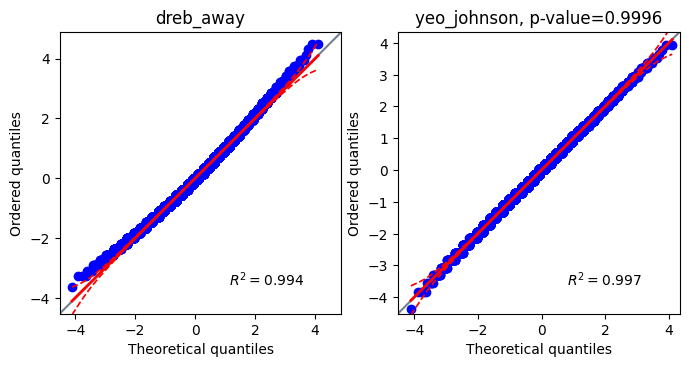

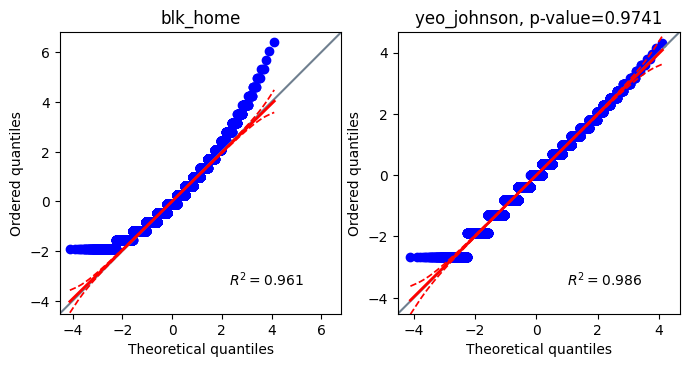

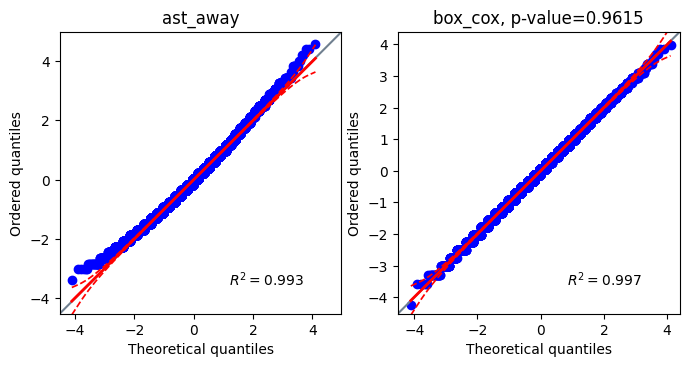

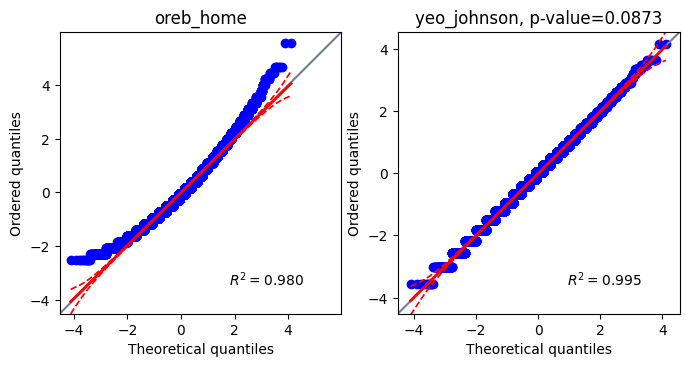

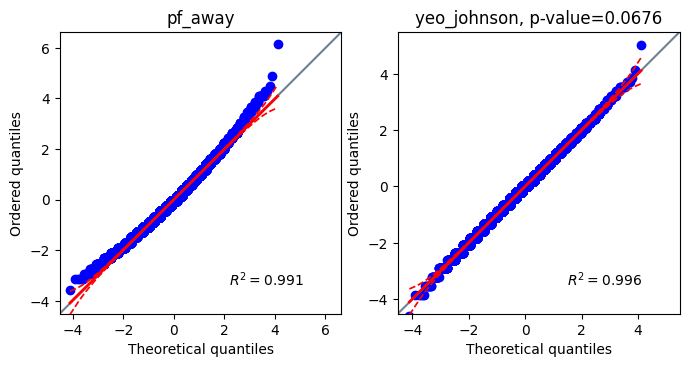

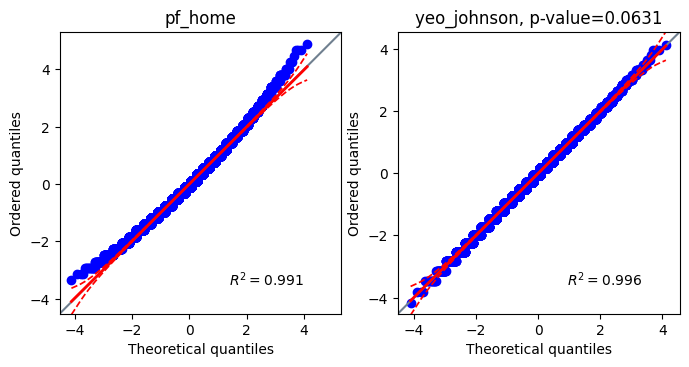

[('dreb_away', 'dreb_away-yeo_johnson', 0.9996), ('blk_home', 'blk_home-yeo_johnson', 0.9741), ('ast_away', 'ast_away-box_cox', 0.9615), ('oreb_away', 'oreb_away-yeo_johnson', 0.9525), ('fta_away', 'fta_away-yeo_johnson', 0.9433), ('fta_home', 'fta_home-box_cox', 0.8999), ('dreb_home', 'dreb_home-yeo_johnson', 0.7077), ('ast_home', 'ast_home-yeo_johnson', 0.4809), ('stl_away', 'stl_away-yeo_johnson', 0.463), ('pts_away', 'pts_away-yeo_johnson', 0.4138), ('stl_home', 'stl_home-yeo_johnson', 0.2554), ('reb_away', 'reb_away-yeo_johnson', 0.1513), ('pts_home', 'pts_home-yeo_johnson', 0.1382), ('fgm_away', 'fgm_away-yeo_johnson', 0.1006), ('oreb_home', 'oreb_home-yeo_johnson', 0.0873), ('pf_away', 'pf_away-yeo_johnson', 0.0676), ('pf_home', 'pf_home-yeo_johnson', 0.0631)]


In [43]:
best_sorted = [(key,value[0],value[1]) for key,value in best.items()]
best_sorted.sort(key=lambda x: x[2], reverse=True)
sample = best_sorted[:3]+best_sorted[-3:]
for item in sample:
    col, transform, pval = item
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
    pg.qqplot(transformed_cols[col][col], dist="norm", ax=axes[0])
    pg.qqplot(transformed_cols[col][transform], dist="norm", ax=axes[1])
    axes[0].set_title(f"{col}")
    transform = transform.split('-')[1]
    axes[1].set_title(f"{transform}, p-value={pval}")
    plt.show()

print(best_sorted)

We now need to add these transformations to our pipeline.

In [44]:
transformer_assignments = {}
print(len(best_sorted))
for term in best_sorted:
    col, transform, pval = term
    transform = transform.split('-')[1]
    if transform in transformer_assignments:
        transformer_assignments[transform].append(col)
    else:
        transformer_assignments[transform] = [col]

print(transformer_assignments)

17
{'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away', 'dreb_home', 'ast_home', 'stl_away', 'pts_away', 'stl_home', 'reb_away', 'pts_home', 'fgm_away', 'oreb_home', 'pf_away', 'pf_home'], 'box_cox': ['ast_away', 'fta_home']}


We will now append the appropriate transformers to our above pipeline.

In [ ]:
base_pipe.steps.append(
    ('yeo_johnson',
    vt.YeoJohnsonTransformer(variables=transformer_assignments['yeo_johnson']))
)

base_pipe.steps.append(
    ('box_cox',
    vt.BoxCoxTransformer(variables=transformer_assignments['box_cox']))
)

We have written this in quite an extensible way and could have used a for loop or list comprehension, but we feel that obscures readability in this case.

## Section 5: Scaling
After the above analysis, we know how we are going to transform our features. All that is left is to assemble the finished pipeline. It will also involve an scaler and another feature selection step, which is standard practice. However, since the feature selection has an argument model and we have not yet chosen our model, we will add that final step in the next notebook.

We now look at the standard scaler.

In [ ]:
from sklearn.preprocessing import StandardScaler

base_pipe.steps.append(('scaler', StandardScaler()))

X_transformed_scaled = base_pipe.fit_transform(X_TrainSet)
cols_dropped = base_pipe['corr_selector'].features_to_drop_
cols_dropped.extend(['season', 'play_off'])
cols = [col for col in X_TrainSet.columns if col not in cols_dropped]
X_transformed_scaled = pd.DataFrame(data=X_transformed_scaled, index=X_TrainSet.index, columns=cols)
print(X_TrainSet.filter(cols).head())
print(cols)
X_transformed_scaled.head()


## Conclusion
We engineered our data in two main ways:
* Removed features to reduce the chance of over-fitting
* Transformed the data so that the distributions were closer to normal distributions

Let's recap the steps that we took. The steps were:

* DropFeatures: `'season'`, `'play_off'`

* SmartCorrelatedSelection: `'fgm_home'`, `'fg3m_home'`, `'ftm_home'`, `'fg3m_away'`, `'ftm_away'`

* YeoJohnsonTransformer: `'dreb_away'`, `'blk_home'`, `'oreb_away'`,
`'fta_away'`, `'dreb_home'`, `'ast_home'`, `'stl_away'`, `'pts_away'`, `'stl_home'`, `'reb_away'`, `'pts_home'`, `'fgm_away'`, `'oreb_home'`, `'pf_away'`, `'pf_home'`

* BoxCoxTransformer: `'ast_away'`, `'fta_home'`


Much of the above was arrived in an automated fashion. We did make one large decision in the cleaning stage: we truncated the data at 1985. We justified this with two arguments:
1. there were many missing values, approximately 10,000 per season and after truncation there were 0 missing values total.
2. truncating only decreased our data set by less than 1/3 and we still have approximately 45,000 games.

Aside from this large choice, we made very few choices. We chose which categorical features to drop, we chose the threshold for SmartCorrelatedSelection, and we chose the most common transformers. These were reasonable decision, but we have left in the threshold as a potential hyperparameter.

Now let's look at the effect of this pipeline on the distributions.

In [ ]:
for col in cols:
  print("\n")
  fig, axes = plt.subplots(figsize=(7,5))
  sns.histplot(data=X_TrainSet, x=col, kde=True, color='r')
  sns.histplot(data=X_transformed_scaled, x=col, kde=True, color='b')
  axes.set_title(f"{col}")
  axes.legend(labels=['Original dist.', 'Transformed dist.'])
  plt.show()
  print("\n")

The transformations may seem drastic. A lot of this is due to the scaling. When plotted on separate axes, `seaborn` adjusts the scale and the distributions look identical. Run the below cell to see.

In [ ]:
for col in cols:
  print('\n')
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
  sns.histplot(data=X_TrainSet, x=col, kde=True, ax=axes[0])
  sns.histplot(data=X_transformed_scaled, x=col, kde=True, ax=axes[1])
  axes[0].set_title(f"{col} before")
  axes[1].set_title(f"{col} after")
  plt.show()
  print("\n")

## Next steps
Now that we have done our feature engineering, we fill do a grid search in order to select the appropriate model. In the next notebook we will select a model.
